In [1]:
from __future__ import print_function

__docformat__ = 'restructedtext en'

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import _pickle as cPickle
import gzip
import os
import sys
import timeit
from sklearn.metrics import confusion_matrix
import math
import os

In [3]:
# Import Theano
# Calculate the time it takes to import Theano
start_time = timeit.default_timer()
import theano
end_time = timeit.default_timer()
print("It took Theano %.1fs to load." % (end_time - start_time))

It took Theano 4.0s to load.


Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 860M (0000:01:00.0)


In [4]:
import theano.tensor as T
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
from theano.printing import pydotprint

In [5]:
# Initialize Random Seed for Randomness

# Set seed for the random numbers
rng = np.random.seed(1234)
rng = np.random.RandomState(1234)

In [6]:
# Import LogisticRegression and load_mnist_data functions from mnist_logistic_regression_model.py

# import LogisticRegression and load_mnist_data functions from mnist_logistic_regression.py
from mnist_logistic_regression_model import LogisticRegression

from load_mnist_dataset import load_mnist_data
dataset = '/home/dashsid/MNIST/mnist.pkl.gz'

# load the dataset
datasets = load_mnist_data(dataset)
    
# retrieve the correct dataset partitions
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

/home/dashsid/MNIST
mnist.pkl.gz
Loading MNIST data...


In [7]:
# Import Hidden Layer from mnist_mlp_model.py
from mnist_mlp_model import HiddenLayer

In [8]:
# Print the no of training, validation, and test data

# Print the type of the shared variable for the dataset
print(train_set_x)

print(train_set_x.get_value())
print(valid_set_x.get_value())
print(test_set_x.get_value())

print("Size of the training dataset: ", train_set_x.get_value().shape)
print("Size of the validation dataset: ", valid_set_x.get_value().shape)
print("Size of the test dataset: ", test_set_x.get_value().shape)

<GpuArrayType<None>(float32, (False, False))>
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Size of the training dataset:  (50000, 784)
Size of the validation dataset:  (10000, 784)
Size of the test dataset:  (10000, 784)


## Define Network and Data Parameters

In [9]:
# Data dimensions

# MNIST images are 28 pixels in each dimension
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size
n_input = img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10
n_output = num_classes

In [10]:
# Configuration of CNN
# Convolutional Layer 1-------------------
# Convolution filters / kernels are 5x5 pixels.
# No.of filters = 16
filter_size1 = 5
# num_filters1 = 32

# Convolutional Layer 2-------------------
filter_size2 = 5
# num_filters2 = 64

# No. of kernels
n_kernels = [32, 32]

# kernel size
kernel_sizes = [(filter_size1, filter_size1), (filter_size2, filter_size2)]

# No. of neurons / units in the Fully Connected Layer
fc_size = 1024

poolsize=(2, 2)

In [11]:
# Training Parameters
learning_rate = 1e-4
batch_size = 256

## Visualize the Data from the Actual Dataset

In [12]:
from utils import tile_raster_images

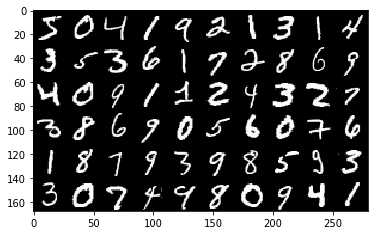

In [13]:
samples = tile_raster_images(train_set_x.get_value(), img_shape=img_shape, 
                             tile_shape=(6, 10), tile_spacing=(0, 0), scale_rows_to_unit_interval=True, 
                             output_pixel_vals=True)
plt.imshow(samples, cmap='gray')
plt.show()

In [14]:
# Print the labels from the dataset
print(train_set_y)

print(train_set_y[:10].eval())

Elemwise{Cast{int32}}.0
[5 0 4 1 9 2 1 3 1 4]


## Data Normalization - PreProcessing

In [15]:
# Apply mean and standard deviation to normalize the data
norm_mean = train_set_x.mean(axis=0)
norm_std =  train_set_x.std(axis=0)
norm_std = norm_std.clip(0.00001, norm_std.max())

# Normalize the training data
train_set_x = train_set_x - norm_mean
train_set_x = train_set_x / norm_std

# Normalize the test data
test_set_x = test_set_x - norm_mean
test_set_x = test_set_x / norm_std

# Normalize the validation data
valid_set_x = valid_set_x - norm_mean
valid_set_x = valid_set_x / norm_std

### Visualize the Pre-Processed Data

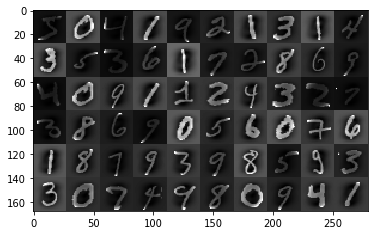

In [16]:
samples = tile_raster_images(train_set_x.eval(), img_shape=(img_size, img_size), 
                             tile_shape=(6, 10), tile_spacing=(0, 0), scale_rows_to_unit_interval=True, 
                             output_pixel_vals=True)
plt.imshow(samples, cmap='gray')
plt.show()

In [17]:
print("Before creating shared variables...")
print(train_set_x)

train_set_x = theano.shared(train_set_x.eval())
valid_set_x = theano.shared(valid_set_x.eval())
test_set_x = theano.shared(test_set_x.eval())

print("After creating shared variables...")
print(train_set_x)
print(valid_set_x)
print(test_set_x)

Before creating shared variables...
Elemwise{true_div,no_inplace}.0
After creating shared variables...
<GpuArrayType<None>(float32, (False, False))>
<GpuArrayType<None>(float32, (False, False))>
<GpuArrayType<None>(float32, (False, False))>


## Create a Class to Setup the LeNet Convolutional Neural Network

In [18]:
class LeNetConvPoolLayer(object):
    
    # Initialize the parameters
    def __init__(self, rng, input, filter_shape, image_shape, poolsize=poolsize):
        
        # Allocate a LeNetConvPoolLayer with shared variable internal parameters.
        
        assert image_shape[1] == filter_shape[1]
        self.input = input
        
        # there are "num input feature maps * filter height * filter width" inputs to each hidden unit
        fan_in = np.prod(filter_shape[1:])
        
        # each unit in the lower layer receives a gradient from: "num output feature maps * 
        # filter height * filter width" pooling size
        fan_out = (filter_shape[0] * np.prod(filter_shape[2:]) // np.prod(poolsize))
        
        # initialize weights with random weights
        W_bound = np.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(np.asarray(rng.uniform(low=-W_bound, high=W_bound, size=filter_shape), 
                                          dtype=theano.config.floatX), borrow=True)
        
        # intialize bias - bias is a 1D tensor; one bias per output feature map
        b_values = np.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)
        
        # convolve input feature maps with filters
        conv_out = conv2d(input=input, filters=self.W, filter_shape=filter_shape, input_shape=image_shape)
        
        # pool each feature map individually, using maxpooling
        # replace ds by ws parameter
        pooled_out = pool.pool_2d(input=conv_out, ws=poolsize, ignore_border=True)
        
        # add the bias term. Since the bias is a vector (1D array), we first reshape it to 
        # a tensor of shape (1, n_filters, 1, 1). Each bias will thus be broadcasted across mini-batches 
        # and feature map width & height
        self.output = T.nnet.relu(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        
        # model parameters
        self.params = [self.W, self.b]
        
        # keep track of model input
        self.input = input

## Declare Placeholders for Theano Shared Variables

In [19]:
# Create symbolic variables for input data, x represents rasterized images, y represents labels
x = T.fmatrix('x')
y = T.ivector('y')

In [20]:
# create a symbolic variable for the index to a minibatch
index = T.lscalar('batch_index')

In [21]:
# compute no of minibatches for training, validation and testing
# // operator is used for integer floor division
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

# n_train_batches = train_set_x.shape[0].eval() // batch_size
print("# of Training batches", n_train_batches)
print("# of Validation batches", n_valid_batches)
print("# of Test batches", n_test_batches)

# of Training batches 195
# of Validation batches 39
# of Test batches 39


## Theano Functions with Shared Variable Input

In [22]:
trainx = train_set_x.eval()
trainy = train_set_y.eval()

validx = valid_set_x.eval()
validy = valid_set_y.eval()

testx = test_set_x.eval()
testy = test_set_y.eval()

## Construct the LeNet CNN Model

In [23]:
print("Building the CNN model.....")

Building the CNN model.....


### Layer 0 - First Convolutional Layer

In [24]:
print("Building the First Convolutional Layer")

# --------First Convolutional Layer-------------------------------
# construct the first convolutional pooling layer
# 16 5x5 filters
# filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
# maxpooling reduces this further to (24/2, 24/2) = (12, 12)
# 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)

# reshape matrix of rasterized images (x) of shape (batch_size, 28 * 28) to a 4D tensor
layer0_input_size = (batch_size, 1, img_size, img_size)
print(layer0_input_size)

layer0_input = x.reshape(layer0_input_size)

# Downsample the image and apply max-pooling
downsampled_img_size1 = (img_size - kernel_sizes[0][0] + 1)
print(downsampled_img_size1)

maxpooled_img_size1 = downsampled_img_size1 // 2
print(maxpooled_img_size1)

# check to confirm even multiples of 2 before pooling
# assert downsampled_img_size1 % 2 == 0

# layer 0 output
layer0_output_size = (batch_size, n_kernels[0], maxpooled_img_size1, maxpooled_img_size1)
print(layer0_output_size)

layer0 = LeNetConvPoolLayer(rng=rng, 
                            input=layer0_input, 
                            image_shape=layer0_input_size, 
                            filter_shape=(n_kernels[0], 1, kernel_sizes[0][0], kernel_sizes[0][1]), 
                            poolsize=poolsize)

Building the First Convolutional Layer
(256, 1, 28, 28)
24
12
(256, 32, 12, 12)


### Layer 1 - Second Convolutional Layer

In [25]:
print("Building the First Convolutional Layer")

# --------Second Convolutional Layer-------------------------------
# construct the second convolutional pooling layer
# 32 5x5 filters
# filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
# maxpooling reduces this further to (8/2, 8/2) = (4, 4)
# 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)

# size of the input for layer 1 is the size of the layer 0's output
layer1_input_size = layer0_output_size
print(layer1_input_size)

layer1_input = layer0.output

# Downsample the convoluted image from the 1st convolutional layer and apply max-pooling
downsampled_img_size2 = (maxpooled_img_size1 - kernel_sizes[1][0] + 1)
print(downsampled_img_size2)

maxpooled_img_size2 = downsampled_img_size2 // 2
print(maxpooled_img_size2)

# check to confirm even multiples of 2 before pooling
assert downsampled_img_size2 % 2 == 0

# layer 1 output
layer1_output_size = (batch_size, n_kernels[1], maxpooled_img_size2, maxpooled_img_size2)
print(layer1_output_size)

layer1 = LeNetConvPoolLayer(rng=rng, 
                            input=layer1_input, 
                            image_shape=layer1_input_size, 
                            filter_shape=(n_kernels[1], n_kernels[0], kernel_sizes[1][0], kernel_sizes[1][1]), 
                            poolsize=poolsize)

Building the First Convolutional Layer
(256, 32, 12, 12)
8
4
(256, 32, 4, 4)


### Layer 2 - Fully Connected Layer - 1

In [26]:
print("Building the Fully Connected Layer - 1")

# --------Fully Connected Layer-------------------------------
# the HiddenLayer being fully-connected, it operates on 2D matrices of
# shape (batch_size, num_pixels) (i.e matrix of rasterized images).
# This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
# or (500, 50 * 4 * 4) = (500, 800) with the default values.

# flatten the output of layer 1 to be used as input for layer 2
# input is required to be in the form of a vector due to sigmoid or tanh activation function
layer2_input = layer1.output.flatten(2)

# construct a fully-connected sigmoidal layer
layer2 = HiddenLayer(rng, 
                     input=layer2_input, 
                     n_in=n_kernels[1] * maxpooled_img_size2 * maxpooled_img_size2, 
                     n_out=fc_size, 
                     activation=T.nnet.relu)

Building the Fully Connected Layer - 1


### Layer 3 - Logistic Regression Output Layer

In [27]:
print("Building the Logistic Regression Output Layer to normalize the output from FC Layer - 1")

# classify the values of the fully-connected sigmoidal layer
layer3_input = layer2.output

layer3 = LogisticRegression(input=layer3_input, n_in=fc_size, n_out=n_output)

Building the Logistic Regression Output Layer to normalize the output from FC Layer - 1


### Loss, Errors, and Accuracy

In [28]:
# find the cost without L1/L2 regularization using the Negative-log-likelihood function
cost = layer3.negative_log_likelihood(y)

# compute the errors
errors = layer3.errors(y)

# compute the accuracy
accuracy = layer3.accuracy(y)

### Gradient Descent

In [29]:
# create a list of all model parameters to be fit by gradient descent
params = layer3.params + layer2.params + layer1.params + layer0.params

# create a list of gradients for all model parameters
grads = T.grad(cost, params)

# Compute the gradient descent step to update the parameters at each learning step for optimization
updates = [(param_i, param_i - learning_rate * grad_i) for param_i, grad_i in zip(params, grads)]

### Theano Functions for Training, Validation, and Testing

In [30]:
# compile the Theano function for the validation model
validate_model = theano.function([index], 
                                 errors, 
                                 givens={x: valid_set_x[index * batch_size: (index + 1) * batch_size], 
                                         y: valid_set_y[index * batch_size: (index + 1) * batch_size]})

# Theano function for validation model accuracy
valid_model_accuracy = theano.function(inputs=[index], 
                                       outputs=accuracy, 
                                       givens={x: valid_set_x[index * batch_size: (index + 1) * batch_size], 
                                               y: valid_set_y[index * batch_size: (index + 1) * batch_size]})

# compile the Theano function for the train model
test_model = theano.function([index], 
                             errors, 
                             givens={x: test_set_x[index * batch_size: (index + 1) * batch_size], 
                                     y: test_set_y[index * batch_size: (index + 1) * batch_size]})

# Theano function for test model accuracy
test_model_accuracy = theano.function(inputs=[index], 
                                      outputs=accuracy, 
                                      givens={x: test_set_x[index * batch_size: (index + 1) * batch_size], 
                                              y: test_set_y[index * batch_size: (index + 1) * batch_size]})

# compile the Theano function for the train model
train_model = theano.function([index], 
                              cost, 
                              updates=updates, 
                              givens={x: train_set_x[index * batch_size: (index + 1) * batch_size], 
                                      y: train_set_y[index * batch_size: (index + 1) * batch_size]})

# Theano function for test model accuracy
train_model_accuracy = theano.function(inputs=[index], 
                                      outputs=accuracy, 
                                      updates=updates, 
                                      givens={x: test_set_x[index * batch_size: (index + 1) * batch_size], 
                                              y: test_set_y[index * batch_size: (index + 1) * batch_size]})

## Perform CNN Model Training

### Helper Function to Perform Optimization

In [31]:
def evaluate_lenet5(learning_rate, n_epochs, dataset, n_kernels, batch_size):
    
    
    # ---------------
    # Train the model
    # ---------------
    print("Training the CNN model...")
    
    
    # keep track of the validation loss and the test scores
    start_time = timeit.default_timer()
    
    # ----------------------------------------------------------
    # Begin the training loop
    # The outer while loop loops over the no of iterations (epochs)
    # The inner loop loops over the minibatches
    finished = False
    curr_epoch = 0
    
    while (curr_epoch < n_epochs) and (not finished):
        
        curr_epoch += 1
        
        for minibatch_i in range(n_train_batches):
            
            # calculate the average likelihood(cost) for the minibatches
            minibatch_avg_cost = train_model(minibatch_i)
            # iteration number
            iter = (curr_epoch - 1) * n_train_batches + minibatch_i
            
            # perform iterations on validation set
            if ((iter + 1) % n_train_batches == 0):
                
                epoch_msg = ("Epoch %i, Minibatch %i/%i ") % (curr_epoch, minibatch_i+1, n_train_batches)
                print(epoch_msg)
                
                # evaluate the train loss on the training batches
                train_loss= [train_model(i) for i in range(n_train_batches)]

                # train_accuracy = [train_model_accuracy(i) for i in range(n_train_batches)]

                # find the average train loss for each training batch
                train_avg_loss = np.mean(train_loss)

                # train_avg_accuracy = np.mean(train_accuracy)
                
                
                # evaluate the validation loss on the validation batches
                valid_loss = [validate_model(i) for i in range(n_valid_batches)]

                valid_accuracy = [valid_model_accuracy(i) for i in range(n_valid_batches)]

                # find the average validation loss for each batch
                valid_avg_loss = np.mean(valid_loss)

                valid_avg_accuracy = np.mean(valid_accuracy)
                
                
                # evaluate the test loss on the test batches
                test_loss = [test_model(i) for i in range(n_test_batches)]

                test_accuracy = [test_model_accuracy(i) for i in range(n_test_batches)]

                # find the average test loss for each batch
                test_avg_loss = np.mean(test_loss)

                test_avg_accuracy = np.mean(test_accuracy)
                
                
                msg = "Validation Accuracy: {0:>6.1%}"
                print(msg.format(valid_avg_accuracy))

                msg1 = ("Training Cost %f %%, Validation Loss %f %%") % (train_avg_loss * 100., valid_avg_loss * 100.)
                print(msg1)
                    
                # serialize the model to disk using pickle
                with open('best_mnist_cnn_model.pkl', 'wb') as f:
                    cPickle.dump(layer3, f)
                    
                print("=====================================================================")
                print("=====================================================================")
                
    end_time = timeit.default_timer()
    
    time_diff = end_time - start_time
    
    train_perf_score = train_avg_loss * 100.
    valid_perf_score = valid_avg_loss * 100.
    test_perf_score = test_avg_loss * 100.
    
    # train_best_accuracy = train_avg_accuracy * 100.
    valid_best_accuracy = valid_avg_accuracy * 100.
    test_best_accuracy = test_avg_accuracy * 100.
    
    print(("Optimization completed with training performance score of %f %%, validation peformance score of %f %%, \
           and test performance score of %f %%") % (train_perf_score, valid_perf_score, test_perf_score))
    
    print(("Validation Accuracy %f %%, and Test Accuracy %f %%") % 
          (valid_best_accuracy, test_best_accuracy))
    
    print("The code ran for %d epochs, with %f epochs/sec" % (curr_epoch, 1. * curr_epoch / time_diff))
    print("The code ran for %.1fs" % time_diff)
    
    print("The code ran for %.2fm" % (time_diff / 60.))

### Execute Optimization

In [32]:
evaluate_lenet5(learning_rate=learning_rate, n_epochs=1000, dataset=dataset, n_kernels=n_kernels, 
                batch_size=batch_size)

Training the CNN model...
Epoch 1, Minibatch 195/195 
Validation Accuracy:  41.4%
Training Cost 228.207612 %, Validation Loss 58.633814 %
Epoch 2, Minibatch 195/195 
Validation Accuracy:  43.4%
Training Cost 225.541162 %, Validation Loss 56.610577 %
Epoch 3, Minibatch 195/195 
Validation Accuracy:  46.1%
Training Cost 222.866035 %, Validation Loss 53.906250 %
Epoch 4, Minibatch 195/195 
Validation Accuracy:  52.2%
Training Cost 220.103168 %, Validation Loss 47.806490 %
Epoch 5, Minibatch 195/195 
Validation Accuracy:  58.7%
Training Cost 217.187691 %, Validation Loss 41.326122 %
Epoch 6, Minibatch 195/195 
Validation Accuracy:  63.5%
Training Cost 214.060950 %, Validation Loss 36.488381 %
Epoch 7, Minibatch 195/195 
Validation Accuracy:  67.7%
Training Cost 210.666633 %, Validation Loss 32.291667 %
Epoch 8, Minibatch 195/195 
Validation Accuracy:  71.1%
Training Cost 206.949496 %, Validation Loss 28.906250 %
Epoch 9, Minibatch 195/195 
Validation Accuracy:  73.7%
Training Cost 202.8561

Epoch 34, Minibatch 195/195 
Validation Accuracy:  86.9%
Training Cost 64.564842 %, Validation Loss 13.090946 %
Epoch 35, Minibatch 195/195 
Validation Accuracy:  87.2%
Training Cost 62.352198 %, Validation Loss 12.810497 %
Epoch 36, Minibatch 195/195 
Validation Accuracy:  87.5%
Training Cost 60.323089 %, Validation Loss 12.520032 %
Epoch 37, Minibatch 195/195 
Validation Accuracy:  87.7%
Training Cost 58.457750 %, Validation Loss 12.289663 %
Epoch 38, Minibatch 195/195 
Validation Accuracy:  88.1%
Training Cost 56.738406 %, Validation Loss 11.929087 %
Epoch 39, Minibatch 195/195 
Validation Accuracy:  88.2%
Training Cost 55.149758 %, Validation Loss 11.758814 %
Epoch 40, Minibatch 195/195 
Validation Accuracy:  88.4%
Training Cost 53.678197 %, Validation Loss 11.598558 %
Epoch 41, Minibatch 195/195 
Validation Accuracy:  88.7%
Training Cost 52.311790 %, Validation Loss 11.348157 %
Epoch 42, Minibatch 195/195 
Validation Accuracy:  88.8%
Training Cost 51.040053 %, Validation Loss 11.1

Epoch 67, Minibatch 195/195 
Validation Accuracy:  91.5%
Training Cost 34.544623 %, Validation Loss 8.453526 %
Epoch 68, Minibatch 195/195 
Validation Accuracy:  91.6%
Training Cost 34.188983 %, Validation Loss 8.413462 %
Epoch 69, Minibatch 195/195 
Validation Accuracy:  91.7%
Training Cost 33.845019 %, Validation Loss 8.333333 %
Epoch 70, Minibatch 195/195 
Validation Accuracy:  91.8%
Training Cost 33.512020 %, Validation Loss 8.223157 %
Epoch 71, Minibatch 195/195 
Validation Accuracy:  91.8%
Training Cost 33.189392 %, Validation Loss 8.193109 %
Epoch 72, Minibatch 195/195 
Validation Accuracy:  91.9%
Training Cost 32.876560 %, Validation Loss 8.133013 %
Epoch 73, Minibatch 195/195 
Validation Accuracy:  92.0%
Training Cost 32.573035 %, Validation Loss 8.032853 %
Epoch 74, Minibatch 195/195 
Validation Accuracy:  92.0%
Training Cost 32.278338 %, Validation Loss 7.992788 %
Epoch 75, Minibatch 195/195 
Validation Accuracy:  92.1%
Training Cost 31.992024 %, Validation Loss 7.882612 %
E

Epoch 100, Minibatch 195/195 
Validation Accuracy:  93.3%
Training Cost 26.685920 %, Validation Loss 6.710737 %
Epoch 101, Minibatch 195/195 
Validation Accuracy:  93.3%
Training Cost 26.524729 %, Validation Loss 6.700721 %
Epoch 102, Minibatch 195/195 
Validation Accuracy:  93.3%
Training Cost 26.366279 %, Validation Loss 6.680689 %
Epoch 103, Minibatch 195/195 
Validation Accuracy:  93.4%
Training Cost 26.210487 %, Validation Loss 6.640625 %
Epoch 104, Minibatch 195/195 
Validation Accuracy:  93.4%
Training Cost 26.057237 %, Validation Loss 6.590545 %
Epoch 105, Minibatch 195/195 
Validation Accuracy:  93.5%
Training Cost 25.906467 %, Validation Loss 6.530449 %
Epoch 106, Minibatch 195/195 
Validation Accuracy:  93.5%
Training Cost 25.758103 %, Validation Loss 6.500401 %
Epoch 107, Minibatch 195/195 
Validation Accuracy:  93.5%
Training Cost 25.612053 %, Validation Loss 6.480369 %
Epoch 108, Minibatch 195/195 
Validation Accuracy:  93.5%
Training Cost 25.468260 %, Validation Loss 6.4

Epoch 133, Minibatch 195/195 
Validation Accuracy:  94.1%
Training Cost 22.454220 %, Validation Loss 5.889423 %
Epoch 134, Minibatch 195/195 
Validation Accuracy:  94.2%
Training Cost 22.352123 %, Validation Loss 5.849359 %
Epoch 135, Minibatch 195/195 
Validation Accuracy:  94.2%
Training Cost 22.251160 %, Validation Loss 5.839343 %
Epoch 136, Minibatch 195/195 
Validation Accuracy:  94.2%
Training Cost 22.151291 %, Validation Loss 5.819311 %
Epoch 137, Minibatch 195/195 
Validation Accuracy:  94.2%
Training Cost 22.052479 %, Validation Loss 5.799279 %
Epoch 138, Minibatch 195/195 
Validation Accuracy:  94.3%
Training Cost 21.954735 %, Validation Loss 5.749199 %
Epoch 139, Minibatch 195/195 
Validation Accuracy:  94.3%
Training Cost 21.858051 %, Validation Loss 5.709135 %
Epoch 140, Minibatch 195/195 
Validation Accuracy:  94.3%
Training Cost 21.762386 %, Validation Loss 5.679087 %
Epoch 141, Minibatch 195/195 
Validation Accuracy:  94.3%
Training Cost 21.667729 %, Validation Loss 5.6

Epoch 166, Minibatch 195/195 
Validation Accuracy:  94.9%
Training Cost 19.580711 %, Validation Loss 5.148237 %
Epoch 167, Minibatch 195/195 
Validation Accuracy:  94.9%
Training Cost 19.506772 %, Validation Loss 5.128205 %
Epoch 168, Minibatch 195/195 
Validation Accuracy:  94.9%
Training Cost 19.433475 %, Validation Loss 5.118189 %
Epoch 169, Minibatch 195/195 
Validation Accuracy:  94.9%
Training Cost 19.360813 %, Validation Loss 5.108173 %
Epoch 170, Minibatch 195/195 
Validation Accuracy:  94.9%
Training Cost 19.288760 %, Validation Loss 5.058093 %
Epoch 171, Minibatch 195/195 
Validation Accuracy:  95.0%
Training Cost 19.217326 %, Validation Loss 5.038061 %
Epoch 172, Minibatch 195/195 
Validation Accuracy:  95.0%
Training Cost 19.146486 %, Validation Loss 5.028045 %
Epoch 173, Minibatch 195/195 
Validation Accuracy:  95.0%
Training Cost 19.076237 %, Validation Loss 4.997997 %
Epoch 174, Minibatch 195/195 
Validation Accuracy:  95.0%
Training Cost 19.006565 %, Validation Loss 4.9

Epoch 199, Minibatch 195/195 
Validation Accuracy:  95.5%
Training Cost 17.430320 %, Validation Loss 4.507212 %
Epoch 200, Minibatch 195/195 
Validation Accuracy:  95.5%
Training Cost 17.373164 %, Validation Loss 4.507212 %
Epoch 201, Minibatch 195/195 
Validation Accuracy:  95.5%
Training Cost 17.316413 %, Validation Loss 4.497196 %
Epoch 202, Minibatch 195/195 
Validation Accuracy:  95.5%
Training Cost 17.260049 %, Validation Loss 4.487179 %
Epoch 203, Minibatch 195/195 
Validation Accuracy:  95.6%
Training Cost 17.204058 %, Validation Loss 4.447115 %
Epoch 204, Minibatch 195/195 
Validation Accuracy:  95.6%
Training Cost 17.148449 %, Validation Loss 4.427083 %
Epoch 205, Minibatch 195/195 
Validation Accuracy:  95.6%
Training Cost 17.093228 %, Validation Loss 4.397035 %
Epoch 206, Minibatch 195/195 
Validation Accuracy:  95.6%
Training Cost 17.038396 %, Validation Loss 4.366987 %
Epoch 207, Minibatch 195/195 
Validation Accuracy:  95.7%
Training Cost 16.983940 %, Validation Loss 4.3

Epoch 232, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.733463 %, Validation Loss 4.016426 %
Epoch 233, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.687454 %, Validation Loss 3.996394 %
Epoch 234, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.641724 %, Validation Loss 3.996394 %
Epoch 235, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.596272 %, Validation Loss 3.986378 %
Epoch 236, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.551087 %, Validation Loss 3.986378 %
Epoch 237, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.506159 %, Validation Loss 3.976362 %
Epoch 238, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.461493 %, Validation Loss 3.956330 %
Epoch 239, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.417098 %, Validation Loss 3.956330 %
Epoch 240, Minibatch 195/195 
Validation Accuracy:  96.0%
Training Cost 15.372960 %, Validation Loss 3.9

Epoch 265, Minibatch 195/195 
Validation Accuracy:  96.3%
Training Cost 14.346476 %, Validation Loss 3.665865 %
Epoch 266, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.308266 %, Validation Loss 3.645833 %
Epoch 267, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.270245 %, Validation Loss 3.635817 %
Epoch 268, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.232421 %, Validation Loss 3.625801 %
Epoch 269, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.194794 %, Validation Loss 3.625801 %
Epoch 270, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.157373 %, Validation Loss 3.625801 %
Epoch 271, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.120145 %, Validation Loss 3.625801 %
Epoch 272, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.083116 %, Validation Loss 3.615785 %
Epoch 273, Minibatch 195/195 
Validation Accuracy:  96.4%
Training Cost 14.046283 %, Validation Loss 3.5

Epoch 298, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 13.184421 %, Validation Loss 3.395433 %
Epoch 299, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 13.152102 %, Validation Loss 3.395433 %
Epoch 300, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 13.119939 %, Validation Loss 3.375401 %
Epoch 301, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 13.087925 %, Validation Loss 3.385417 %
Epoch 302, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 13.056059 %, Validation Loss 3.395433 %
Epoch 303, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 13.024347 %, Validation Loss 3.395433 %
Epoch 304, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 12.992789 %, Validation Loss 3.395433 %
Epoch 305, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 12.961377 %, Validation Loss 3.375401 %
Epoch 306, Minibatch 195/195 
Validation Accuracy:  96.6%
Training Cost 12.930118 %, Validation Loss 3.3

Epoch 331, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.194693 %, Validation Loss 3.225160 %
Epoch 332, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.167011 %, Validation Loss 3.225160 %
Epoch 333, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.139454 %, Validation Loss 3.225160 %
Epoch 334, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.112026 %, Validation Loss 3.215144 %
Epoch 335, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.084724 %, Validation Loss 3.215144 %
Epoch 336, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.057548 %, Validation Loss 3.195112 %
Epoch 337, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.030497 %, Validation Loss 3.195112 %
Epoch 338, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 12.003555 %, Validation Loss 3.195112 %
Epoch 339, Minibatch 195/195 
Validation Accuracy:  96.8%
Training Cost 11.976727 %, Validation Loss 3.1

Epoch 364, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.342586 %, Validation Loss 3.044872 %
Epoch 365, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.318604 %, Validation Loss 3.034856 %
Epoch 366, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.294722 %, Validation Loss 3.004808 %
Epoch 367, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.270940 %, Validation Loss 3.004808 %
Epoch 368, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.247260 %, Validation Loss 3.004808 %
Epoch 369, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.223683 %, Validation Loss 2.994792 %
Epoch 370, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.200213 %, Validation Loss 2.984776 %
Epoch 371, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.176844 %, Validation Loss 2.984776 %
Epoch 372, Minibatch 195/195 
Validation Accuracy:  97.0%
Training Cost 11.153575 %, Validation Loss 2.9

Epoch 397, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.602507 %, Validation Loss 2.874599 %
Epoch 398, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.581611 %, Validation Loss 2.874599 %
Epoch 399, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.560799 %, Validation Loss 2.874599 %
Epoch 400, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.540069 %, Validation Loss 2.874599 %
Epoch 401, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.519426 %, Validation Loss 2.874599 %
Epoch 402, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.498866 %, Validation Loss 2.874599 %
Epoch 403, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.478386 %, Validation Loss 2.884615 %
Epoch 404, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.457993 %, Validation Loss 2.874599 %
Epoch 405, Minibatch 195/195 
Validation Accuracy:  97.1%
Training Cost 10.437673 %, Validation Loss 2.8

Epoch 430, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.953971 %, Validation Loss 2.774439 %
Epoch 431, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.935579 %, Validation Loss 2.774439 %
Epoch 432, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.917255 %, Validation Loss 2.774439 %
Epoch 433, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.898995 %, Validation Loss 2.774439 %
Epoch 434, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.880804 %, Validation Loss 2.774439 %
Epoch 435, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.862683 %, Validation Loss 2.774439 %
Epoch 436, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.844629 %, Validation Loss 2.774439 %
Epoch 437, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.826639 %, Validation Loss 2.754407 %
Epoch 438, Minibatch 195/195 
Validation Accuracy:  97.2%
Training Cost 9.808718 %, Validation Loss 2.754407 %
E

Epoch 463, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.381809 %, Validation Loss 2.644231 %
Epoch 464, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.365528 %, Validation Loss 2.644231 %
Epoch 465, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.349304 %, Validation Loss 2.644231 %
Epoch 466, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.333139 %, Validation Loss 2.644231 %
Epoch 467, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.317026 %, Validation Loss 2.644231 %
Epoch 468, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.300970 %, Validation Loss 2.644231 %
Epoch 469, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.284973 %, Validation Loss 2.634215 %
Epoch 470, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.269035 %, Validation Loss 2.634215 %
Epoch 471, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 9.253158 %, Validation Loss 2.624199 %
E

Epoch 496, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 8.874136 %, Validation Loss 2.564103 %
Epoch 497, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 8.859654 %, Validation Loss 2.564103 %
Epoch 498, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 8.845226 %, Validation Loss 2.554087 %
Epoch 499, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 8.830850 %, Validation Loss 2.554087 %
Epoch 500, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 8.816522 %, Validation Loss 2.554087 %
Epoch 501, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.802246 %, Validation Loss 2.544071 %
Epoch 502, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.788018 %, Validation Loss 2.544071 %
Epoch 503, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.773841 %, Validation Loss 2.544071 %
Epoch 504, Minibatch 195/195 
Validation Accuracy:  97.4%
Training Cost 8.759715 %, Validation Loss 2.554087 %
E

Epoch 529, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.421525 %, Validation Loss 2.473958 %
Epoch 530, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.408581 %, Validation Loss 2.463942 %
Epoch 531, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.395681 %, Validation Loss 2.473958 %
Epoch 532, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.382826 %, Validation Loss 2.473958 %
Epoch 533, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.370009 %, Validation Loss 2.473958 %
Epoch 534, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.357235 %, Validation Loss 2.473958 %
Epoch 535, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.344501 %, Validation Loss 2.463942 %
Epoch 536, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.331808 %, Validation Loss 2.463942 %
Epoch 537, Minibatch 195/195 
Validation Accuracy:  97.5%
Training Cost 8.319157 %, Validation Loss 2.463942 %
E

Epoch 562, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 8.016082 %, Validation Loss 2.413862 %
Epoch 563, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 8.004464 %, Validation Loss 2.403846 %
Epoch 564, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 7.992886 %, Validation Loss 2.403846 %
Epoch 565, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 7.981341 %, Validation Loss 2.403846 %
Epoch 566, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 7.969831 %, Validation Loss 2.383814 %
Epoch 567, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 7.958359 %, Validation Loss 2.383814 %
Epoch 568, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 7.946919 %, Validation Loss 2.383814 %
Epoch 569, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 7.935514 %, Validation Loss 2.383814 %
Epoch 570, Minibatch 195/195 
Validation Accuracy:  97.6%
Training Cost 7.924142 %, Validation Loss 2.383814 %
E

Epoch 595, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.651157 %, Validation Loss 2.303686 %
Epoch 596, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.640663 %, Validation Loss 2.303686 %
Epoch 597, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.630198 %, Validation Loss 2.303686 %
Epoch 598, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.619769 %, Validation Loss 2.313702 %
Epoch 599, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.609371 %, Validation Loss 2.303686 %
Epoch 600, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.599008 %, Validation Loss 2.303686 %
Epoch 601, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.588675 %, Validation Loss 2.293670 %
Epoch 602, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.578366 %, Validation Loss 2.293670 %
Epoch 603, Minibatch 195/195 
Validation Accuracy:  97.7%
Training Cost 7.568085 %, Validation Loss 2.293670 %
E

Epoch 628, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.321398 %, Validation Loss 2.223558 %
Epoch 629, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.311915 %, Validation Loss 2.223558 %
Epoch 630, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.302460 %, Validation Loss 2.223558 %
Epoch 631, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.293031 %, Validation Loss 2.223558 %
Epoch 632, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.283629 %, Validation Loss 2.223558 %
Epoch 633, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.274251 %, Validation Loss 2.223558 %
Epoch 634, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.264902 %, Validation Loss 2.213542 %
Epoch 635, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.255578 %, Validation Loss 2.213542 %
Epoch 636, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.246283 %, Validation Loss 2.213542 %
E

Epoch 661, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.022284 %, Validation Loss 2.183494 %
Epoch 662, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.013631 %, Validation Loss 2.173478 %
Epoch 663, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 7.005000 %, Validation Loss 2.173478 %
Epoch 664, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 6.996392 %, Validation Loss 2.173478 %
Epoch 665, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 6.987812 %, Validation Loss 2.183494 %
Epoch 666, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 6.979252 %, Validation Loss 2.173478 %
Epoch 667, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 6.970712 %, Validation Loss 2.173478 %
Epoch 668, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 6.962194 %, Validation Loss 2.153446 %
Epoch 669, Minibatch 195/195 
Validation Accuracy:  97.8%
Training Cost 6.953699 %, Validation Loss 2.153446 %
E

Epoch 694, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.748311 %, Validation Loss 2.133413 %
Epoch 695, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.740370 %, Validation Loss 2.133413 %
Epoch 696, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.732450 %, Validation Loss 2.133413 %
Epoch 697, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.724551 %, Validation Loss 2.143429 %
Epoch 698, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.716671 %, Validation Loss 2.143429 %
Epoch 699, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.708809 %, Validation Loss 2.143429 %
Epoch 700, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.700969 %, Validation Loss 2.143429 %
Epoch 701, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.693150 %, Validation Loss 2.133413 %
Epoch 702, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.685352 %, Validation Loss 2.133413 %
E

Epoch 727, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.496770 %, Validation Loss 2.073317 %
Epoch 728, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.489473 %, Validation Loss 2.073317 %
Epoch 729, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.482195 %, Validation Loss 2.073317 %
Epoch 730, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.474937 %, Validation Loss 2.083333 %
Epoch 731, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.467695 %, Validation Loss 2.083333 %
Epoch 732, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.460465 %, Validation Loss 2.083333 %
Epoch 733, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.453254 %, Validation Loss 2.083333 %
Epoch 734, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.446061 %, Validation Loss 2.083333 %
Epoch 735, Minibatch 195/195 
Validation Accuracy:  97.9%
Training Cost 6.438883 %, Validation Loss 2.083333 %
E

Epoch 760, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.265050 %, Validation Loss 2.023237 %
Epoch 761, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.258320 %, Validation Loss 2.023237 %
Epoch 762, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.251610 %, Validation Loss 2.023237 %
Epoch 763, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.244915 %, Validation Loss 2.023237 %
Epoch 764, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.238234 %, Validation Loss 2.023237 %
Epoch 765, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.231566 %, Validation Loss 2.013221 %
Epoch 766, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.224913 %, Validation Loss 2.003205 %
Epoch 767, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.218274 %, Validation Loss 2.003205 %
Epoch 768, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.211654 %, Validation Loss 2.003205 %
E

Epoch 793, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.051105 %, Validation Loss 1.973157 %
Epoch 794, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.044879 %, Validation Loss 1.973157 %
Epoch 795, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.038666 %, Validation Loss 1.973157 %
Epoch 796, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.032464 %, Validation Loss 1.973157 %
Epoch 797, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.026277 %, Validation Loss 1.973157 %
Epoch 798, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.020106 %, Validation Loss 1.953125 %
Epoch 799, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.013947 %, Validation Loss 1.953125 %
Epoch 800, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.007801 %, Validation Loss 1.953125 %
Epoch 801, Minibatch 195/195 
Validation Accuracy:  98.0%
Training Cost 6.001674 %, Validation Loss 1.953125 %
E

Epoch 826, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.852693 %, Validation Loss 1.923077 %
Epoch 827, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.846899 %, Validation Loss 1.923077 %
Epoch 828, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.841117 %, Validation Loss 1.923077 %
Epoch 829, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.835350 %, Validation Loss 1.923077 %
Epoch 830, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.829593 %, Validation Loss 1.923077 %
Epoch 831, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.823850 %, Validation Loss 1.923077 %
Epoch 832, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.818122 %, Validation Loss 1.923077 %
Epoch 833, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.812403 %, Validation Loss 1.923077 %
Epoch 834, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.806697 %, Validation Loss 1.923077 %
E

Epoch 859, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.668014 %, Validation Loss 1.883013 %
Epoch 860, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.662620 %, Validation Loss 1.883013 %
Epoch 861, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.657238 %, Validation Loss 1.883013 %
Epoch 862, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.651867 %, Validation Loss 1.883013 %
Epoch 863, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.646509 %, Validation Loss 1.883013 %
Epoch 864, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.641162 %, Validation Loss 1.883013 %
Epoch 865, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.635821 %, Validation Loss 1.883013 %
Epoch 866, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.630496 %, Validation Loss 1.883013 %
Epoch 867, Minibatch 195/195 
Validation Accuracy:  98.1%
Training Cost 5.625179 %, Validation Loss 1.883013 %
E

Epoch 892, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.495772 %, Validation Loss 1.832933 %
Epoch 893, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.490730 %, Validation Loss 1.832933 %
Epoch 894, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.485694 %, Validation Loss 1.832933 %
Epoch 895, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.480671 %, Validation Loss 1.832933 %
Epoch 896, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.475657 %, Validation Loss 1.832933 %
Epoch 897, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.470653 %, Validation Loss 1.832933 %
Epoch 898, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.465659 %, Validation Loss 1.832933 %
Epoch 899, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.460678 %, Validation Loss 1.832933 %
Epoch 900, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.455700 %, Validation Loss 1.832933 %
E

Epoch 925, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.334375 %, Validation Loss 1.792869 %
Epoch 926, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.329645 %, Validation Loss 1.792869 %
Epoch 927, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.324924 %, Validation Loss 1.792869 %
Epoch 928, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.320209 %, Validation Loss 1.792869 %
Epoch 929, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.315502 %, Validation Loss 1.792869 %
Epoch 930, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.310806 %, Validation Loss 1.792869 %
Epoch 931, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.306117 %, Validation Loss 1.792869 %
Epoch 932, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.301436 %, Validation Loss 1.792869 %
Epoch 933, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.296767 %, Validation Loss 1.792869 %
E

Epoch 958, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.182787 %, Validation Loss 1.762821 %
Epoch 959, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.178334 %, Validation Loss 1.762821 %
Epoch 960, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.173891 %, Validation Loss 1.762821 %
Epoch 961, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.169456 %, Validation Loss 1.762821 %
Epoch 962, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.165029 %, Validation Loss 1.762821 %
Epoch 963, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.160611 %, Validation Loss 1.762821 %
Epoch 964, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.156200 %, Validation Loss 1.762821 %
Epoch 965, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.151802 %, Validation Loss 1.762821 %
Epoch 966, Minibatch 195/195 
Validation Accuracy:  98.2%
Training Cost 5.147409 %, Validation Loss 1.762821 %
E

Epoch 991, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.040239 %, Validation Loss 1.742788 %
Epoch 992, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.036056 %, Validation Loss 1.742788 %
Epoch 993, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.031878 %, Validation Loss 1.742788 %
Epoch 994, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.027708 %, Validation Loss 1.742788 %
Epoch 995, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.023547 %, Validation Loss 1.742788 %
Epoch 996, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.019389 %, Validation Loss 1.742788 %
Epoch 997, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.015239 %, Validation Loss 1.742788 %
Epoch 998, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.011098 %, Validation Loss 1.742788 %
Epoch 999, Minibatch 195/195 
Validation Accuracy:  98.3%
Training Cost 5.006962 %, Validation Loss 1.742788 %
E

## Helper Function to Plot Weights

In [33]:
def plot_weights(weights, image_shape, tile_shape, cmap):
    
    # print statistics for the weights
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(weights.min(), weights.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(weights.mean(), weights.std()))
    
    filters = tile_raster_images(weights, img_shape=image_shape, tile_shape=tile_shape, tile_spacing=(1, 1), 
                                 scale_rows_to_unit_interval=True, output_pixel_vals=True)
        
    # plot the weights
    plt.imshow(filters, cmap=cmap)
    plt.show()

In [34]:
layer0_arr = layer0.W.get_value(borrow=True)
W_shape = layer0_arr.shape
print(W_shape)

(32, 1, 5, 5)


## Plot the Hidden Layer Weights

In [35]:
# hidden_weights = LeNetConvPoolLayer.hiddenLayers[0].W.T.eval()

# hidden_weights0 = layer0.W.T.eval()
# hidden_weights1 = layer1.W.T.eval()
# hidden_weights2 = layer2.W.T.eval()
hidden_weights3 = layer3.W.T.eval()

Min:  -0.10397, Max:   0.10172
Mean: 0.00000, Stdev: 0.02322


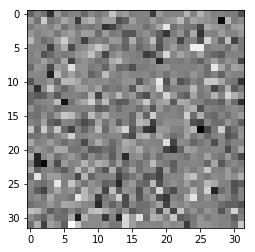

In [36]:
plot_weights(hidden_weights3, image_shape=(32,32), tile_shape=(1, 1), cmap='gray')